# Principal Component Analysis

In [1]:
# Obtain all principal components of the training set, then extract the first two
# Principal Components

import numpy as np
X_centered = X - X.mean(axis = 0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

NameError: name 'X' is not defined

In [ ]:
# Project the training set onto the plane defined by the first two principal components
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

## Using Scikit-Learn

In [ ]:
# Apply PCA to reduce the dimensionality of the dataset down to 2D
# (the data is automatically centered)

from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [ ]:
# Compute PCA without reducing dimensionality then
# compute the min number of dimensions required to preserve 95% variance

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

# There's a better option! Set n_components to 0.95:

pca = PCA(n_components = 0.95)
X_reduced = pca.fit_transform(X_train)

## Incremental PCA

In [ ]:
# Split the MNIST dataset into 100 mini-batches and feed them to sklearn's IncrementalPCA class
# to again reduce the dimensionality. Note we must call the partial_fit() method with each
# mini-batch rather than the fit() method with the whole training set

from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components = 154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)
    
X_reduced = inc_pca.transform(X_train)

In [ ]:
# Or we can use memmap, then use fit() as normal

X_mm = np.memmap(filename, dtype = 'float32', mode = 'readonly', shape = (m,n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components = 154, batch_size = batch_size)
inc_pca.fit(X_mm)


## Randomized PCA

In [ ]:
rnd_pca = PCA(n_components = 154, svd_solver = 'randomized')
X_reduced = rnd_pca.fit_transform(X_train)

# Kernel PCA

In [ ]:
# Use KernelPCA class to perform kPCA with an RBF kernel

from sklearn.decomposition import KernelPCA

rbc_pca = KernelPCA(n_components = 2, kernel = 'rbf', gamma = 0.04)
X_reduced = rbf_pca.fit_transform(X)

## Selecting a Kernel and Tuning Hyperparameters

In [ ]:
# Create a two-step pipeline: first reduce dimensionality to 2D using kPCA,
# then apply Logistic Regression for classification. Then use GridSearchCV
# to find the best kernel and gamma value for kPCA in order to get the best
# classification accuracy at the end of the pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ('kpca', KernelPCA(n_components = 2)),
    ('log_reg', LogisticRegression())
])

param_grid = [{
    'kpca__gamma' : np.linspace(0.03, 0.05, 10),
    'kpca__kernel' : ['rbf', 'sigmoid']
}]

grid_search = GridSearchCV(clf, param_grid, cv = 3)
grid_search.fit(X, y)

# The best kernel and hyperparameters are available through the best_params_ variable:

print(grid_search.best_params_)

In [ ]:
# In order to find lowest reconstruction error, train a supervised regression model with the projected
# instances as the training set and the original instances as the targets:

rbf_pca = KernelPCA(n_components = 2, kernel = 'rbf', gamma = 0.0433,
                   fit_inverse_transform = True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

# Now compute the reconstruction pre-image error
from sklearn.metrics import mean_squared_error
mean_squared_error(X, X_preimage)

# Finally use grid search with cross validation to find the kernel and hyperparamters that
# minimize this pre-image reconstruction error

# LLE

In [ ]:
# Use the LocallyLinearEmbedding class to unroll the Swiss roll

from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components = 2, n_neighbors = 10)
X_reduced = lle.fit_transform(X)

# Exercises
## #9

In [1]:
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split

mnist = fetch_mldata('MNIST original')
X, y = mnist["data"], mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 10000, random_state = 0)
X_train.shape



(60000, 784)

In [2]:
X_test.shape

(10000, 784)

In [3]:
y_train.shape

(60000,)

In [4]:
y_test.shape

(10000,)

In [10]:
from sklearn.ensemble import RandomForestClassifier
import time

rf_clf = RandomForestClassifier(random_state = 0)
start = time.time()
rf_clf.fit(X_train, y_train)
end = time.time()

print(end - start)


4.670855283737183


In [16]:
from sklearn.metrics import accuracy_score

y_pred = rf_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.9495


In [12]:
# Now do the same thing, but with dimensionality reduction first using PCA

from sklearn.decomposition import PCA
pca = PCA(n_components = 0.95)
X_reduced = pca.fit_transform(X_train)

In [14]:
rf_clf2 = RandomForestClassifier(random_state = 0)
start = time.time()
rf_clf2.fit(X_reduced, y_train)
end = time.time()

print(end - start)

9.261409044265747


In [18]:
X_test_reduced = pca.transform(X_test)
y_pred2 = rf_clf2.predict(X_test_reduced)
print(accuracy_score(y_test, y_pred2))

0.8914


In [19]:
# Now try softmax regression
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
t0 = time.time()
log_clf.fit(X_train, y_train)
t1 = time.time()

In [20]:
print("Training took {:.2f}s".format(t1 - t0))


Training took 20.77s


In [21]:


y_pred = log_clf.predict(X_test)
accuracy_score(y_test, y_pred)



0.919

In [23]:
log_clf2 = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
t0 = time.time()
log_clf2.fit(X_reduced, y_train)
t1 = time.time()

In [24]:
y_pred = log_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.915

In [25]:
print("Training took {:.2f}s".format(t1 - t0))

Training took 7.80s


In [26]:
# So here PCA was extremely useful.

## #10

In [27]:
from sklearn.manifold import TSNE

mnist = fetch_mldata('MNIST original')


In [29]:
import numpy as np

np.random.seed(42)

m = 10000
idx = np.random.permutation(60000)[:m]

X = mnist['data'][idx]
y = mnist['target'][idx]



In [30]:
tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

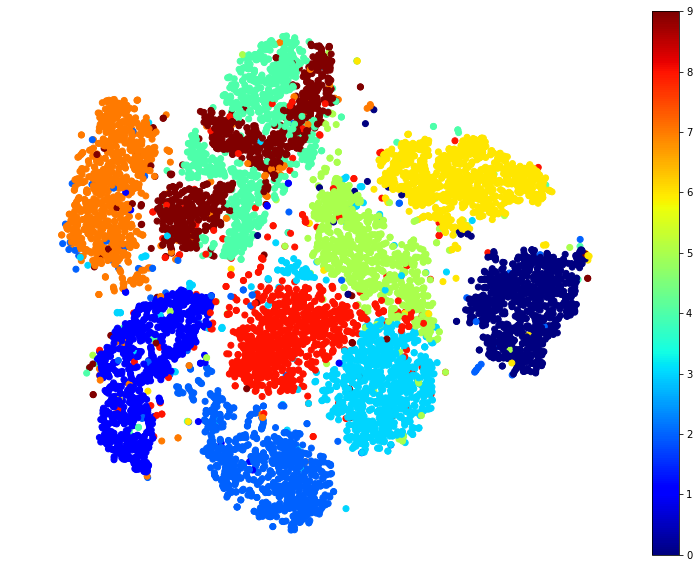

In [33]:
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline

plt.figure(figsize=(13,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="jet")
plt.axis('off')
plt.colorbar()



In [34]:
# Now try other methods. First is PCA:
pca = PCA(n_components = 0.95)
X_reduced2 = pca.fit_transform(X)

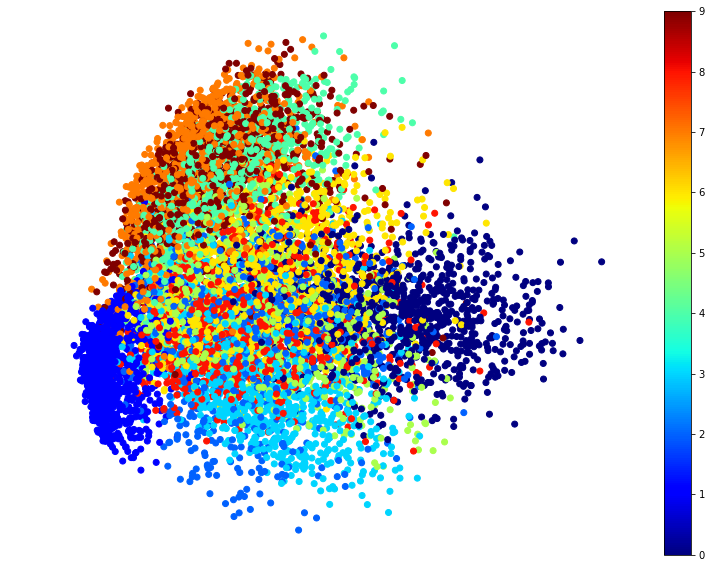

In [35]:
plt.figure(figsize=(13,10))
plt.scatter(X_reduced2[:, 0], X_reduced2[:, 1], c=y, cmap="jet")
plt.axis('off')
plt.colorbar()

In [40]:
# Now LLE

from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components = 2, random_state = 42)
X_reduced3 = lle.fit_transform(X)

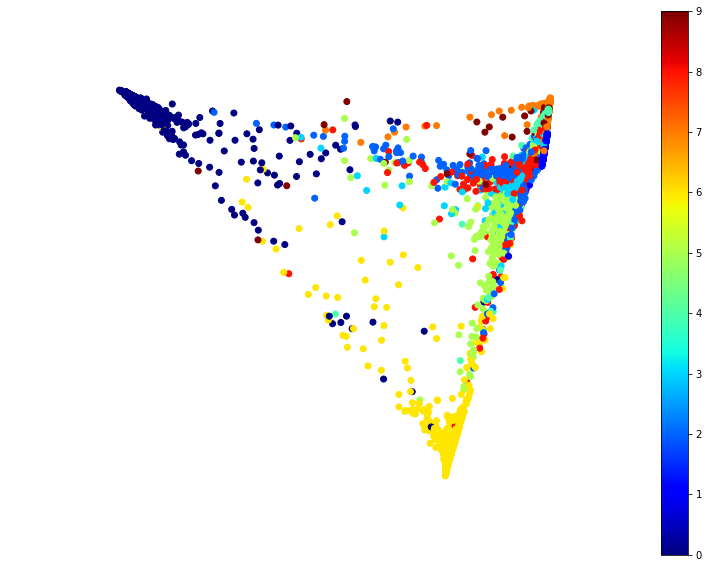

In [41]:
plt.figure(figsize=(13,10))
plt.scatter(X_reduced3[:, 0], X_reduced3[:, 1], c=y, cmap="jet")
plt.axis('off')
plt.colorbar()

In [42]:
# Finally MDS
from sklearn.manifold import MDS

m = 2000
X_mds_reduced = MDS(n_components=2, random_state=42).fit_transform(X[:m])

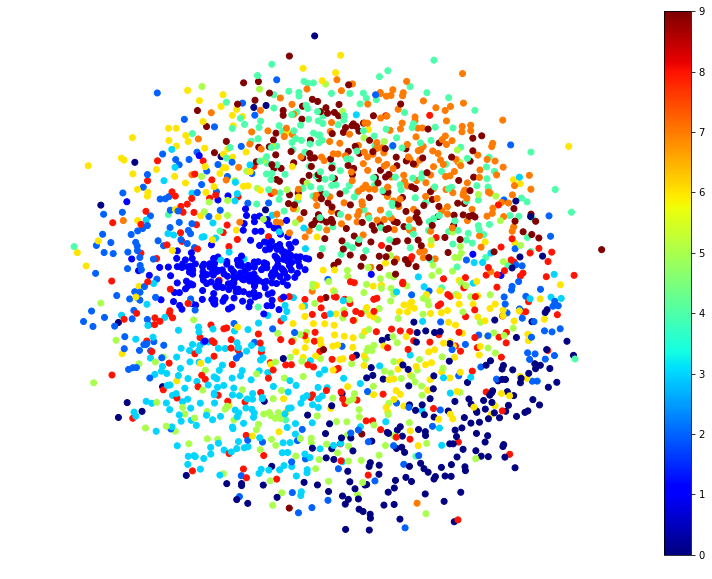

In [44]:
plt.figure(figsize=(13,10))
plt.scatter(X_mds_reduced[:, 0], X_mds_reduced[:, 1], c=y[:m], cmap="jet")
plt.axis('off')
plt.colorbar()